<a href="https://colab.research.google.com/github/gulabpatel/TimeSeries/blob/main/25_Orbit_MMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Documentation :

https://forecastegy.com/posts/implementing-uber-marketing-mix-model-with-orbit/

In [ ]:
!pip install orbit-ml
!pip install nevergrad
!apt-get install msttcorefonts -qq

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
from sklearn.preprocessing import MaxAbsScaler 
from sklearn import metrics
import orbit
from orbit.models import KTR
from orbit.diagnostics.metrics import smape
pd.set_option('display.float_format', lambda x: '%.5f' %x)

In [3]:
# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from google.auth import default
# creds, _ = default()
# gc = gspread.authorize(creds)



# spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/17bDNWpue0Cf5YFfgOqq0d_3inEnRE4aKcx1PGgOW_mM/edit?usp=sharing')
# sheet = spreadsheet.get_worksheet(0)
# data = pd.DataFrame(sheet.get_all_records())
# data.head(10)

In [4]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/APIKeys/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download saicharansirangi/adanalyse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
  0% 0.00/757k [00:00<?, ?B/s]
100% 757k/757k [00:00<00:00, 42.8MB/s]


In [5]:
! unzip adanalyse.zip

Archive:  adanalyse.zip
  inflating: Sr Advertising Analyst Work Sample (1).xlsx  


In [6]:
data = pd.read_excel('/content/Sr Advertising Analyst Work Sample (1).xlsx')
data

,Date,Brand Alias,Ad group alias,ASIN/SKU Alias,Marketplace,Impressions,Clicks,Spend,Sales,Orders,Units,Advertised Units sold,Other SKU units sold,Advertised SKU Sales,Other SKU sales
0,2021-10-17,Brand 1,Brand 1 Ad Group 10,ASIN414,Walmart,33,0,0.00000,0.00000,0,0,0,0,0.00000,0.00000
1,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN385,Walmart,0,0,0.00000,0.00000,0,0,0,0,0.00000,0.00000
2,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN389,Walmart,0,0,0.00000,0.00000,0,0,0,0,0.00000,0.00000
3,2021-10-17,Brand 1,Brand 1 Ad Group 13,ASIN377,Walmart,380,8,2.34000,0.00000,0,0,0,0,0.00000,0.00000
4,2021-10-17,Brand 1,Brand 1 Ad Group 13,ASIN399,Walmart,3805,7,6.68400,0.00000,0,0,0,0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9581,2022-01-11,Brand 2,Brand 2 Ad Group 2,ASIN508,Amazon,4639,10,7.36000,0.00000,0,0,0,0,0.00000,0.00000
9582,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN512,Amazon,15336,49,33.79000,638.73750,6,6,1,5,55.99000,455.00000
9583,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN516,Amazon,4811,6,3.66000,0.00000,0,0,0,0,0.00000,0.00000
9584,2022-01-11,Brand 2,Brand 2 Ad Group 3,ASIN520,Amazon,22838,36,19.57000,294.95000,4,4,3,1,158.97000,76.99000


In [7]:
#Convert the data format
data['Date'] = pd.to_datetime(data['Date'], format='%b %d, %Y')

In [8]:
data[["Impressions","Spend", "Sales"]].dtypes

Impressions      int64
Spend          float64
Sales          float64
dtype: object

In [9]:
agg_data = data.groupby(["Date", "Ad group alias"])[["Impressions","Spend", "Sales",]].sum()
agg_data = agg_data.drop(["Brand 1 Ad Group 12"], axis=0, level=1) # zero cost train

media_data_raw = agg_data['Impressions'].unstack().fillna(0)
costs_raw = agg_data['Spend'].unstack()
sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()
media_data_raw["Sales"] = sales_raw

media_data_raw = media_data_raw.reset_index()
media_data_raw.head()

<ipython-input-9-e00ddf7b1fa9>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()


Ad group alias,Date,Brand 1 Ad Group 1,Brand 1 Ad Group 10,Brand 1 Ad Group 11,Brand 1 Ad Group 13,Brand 1 Ad Group 2,Brand 1 Ad Group 3,Brand 1 Ad Group 4,Brand 1 Ad Group 5,Brand 1 Ad Group 6,...,Brand 1 Ad Group 8,Brand 1 Ad Group 9,Brand 2 Ad Group 1,Brand 2 Ad Group 2,Brand 2 Ad Group 3,Brand 2 Ad Group 4,Brand 2 Ad Group 5,Brand 1 Ad Group 14,Brand 2 Ad Group 6,Sales
0,2021-10-17,3317.00000,33.00000,50966.00000,9519.00000,40265.00000,0.00000,142704.00000,55.00000,94.00000,...,248.00000,23321.00000,276437.00000,424883.00000,135366.00000,41905.00000,9871.00000,0.00000,0.00000,28195.05750
1,2021-10-18,1501.00000,30.00000,39424.00000,14015.00000,18545.00000,0.00000,389663.00000,53.00000,121.00000,...,283.00000,28321.00000,313907.00000,492277.00000,119675.00000,46550.00000,19920.00000,50619.00000,0.00000,25490.77500
2,2021-10-19,771.00000,63.00000,236572.00000,16543.00000,13078.00000,0.00000,810070.00000,58.00000,122.00000,...,245.00000,26105.00000,296159.00000,475287.00000,191075.00000,0.00000,9253.00000,43019.00000,0.00000,34054.93750
3,2021-10-20,958.00000,70.00000,277649.00000,24590.00000,10743.00000,0.00000,821705.00000,60.00000,111.00000,...,234.00000,0.00000,314952.00000,641517.00000,98214.00000,61017.00000,18669.00000,45642.00000,0.00000,30204.40500
4,2021-10-21,1841.00000,59.00000,251202.00000,14236.00000,10799.00000,0.00000,1241204.00000,72.00000,150.00000,...,394.00000,0.00000,392621.00000,412898.00000,88922.00000,121214.00000,12977.00000,69165.00000,0.00000,34461.20500


In [10]:
date_col = "Date"
response_col = "Sales"

regressor_col = ['Brand 1 Ad Group 1', 'Brand 1 Ad Group 10',
       'Brand 1 Ad Group 11', 'Brand 1 Ad Group 13', 'Brand 1 Ad Group 2',
       'Brand 1 Ad Group 3', 'Brand 1 Ad Group 4', 'Brand 1 Ad Group 5',
       'Brand 1 Ad Group 6', 'Brand 1 Ad Group 7', 'Brand 1 Ad Group 8',
       'Brand 1 Ad Group 9', 'Brand 2 Ad Group 1', 'Brand 2 Ad Group 2',
       'Brand 2 Ad Group 3', 'Brand 2 Ad Group 4', 'Brand 2 Ad Group 5',
       'Brand 1 Ad Group 14', 'Brand 2 Ad Group 6']
split_point = -28 # 28 days to end of data

media_data_train = media_data_raw.iloc[:split_point].copy()
media_data_test = media_data_raw.iloc[split_point:].copy()

scaler = MaxAbsScaler() # better than standard
media_data_train.loc[:, regressor_col] = scaler.fit_transform(media_data_train.loc[:, regressor_col])
media_data_test.loc[:, regressor_col] = scaler.transform(media_data_test.loc[:, regressor_col])

scaler_y = MaxAbsScaler()
media_data_train.loc[:, response_col] = scaler_y.fit_transform(media_data_train.loc[:, response_col].values.reshape(-1,1))

media_names = media_data_raw.columns

## Building the Model


We need to pass a list of columns to use as regressors (inputs).

If we don’t, Orbit will only create a simple time series model with the target variable and date, which is not our goal here.

We can specify seasonality. Here I put 7 to allow for weekday seasonality, but if we had more data, we could put 365.25 as they suggest in the documentation, to capture yearly seasonality effects (like Christmas and Black Friday).

In [11]:
ktr_ = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    #regressor_sign=["+"]*len(regressor_col), # strictly positive signs hurt MAPE but can be useful to interpret?
    seed=2021,
    seasonality=[7], # cant use 365 seasonality because have only 59 rows
    estimator='pyro-svi',
    n_bootstrap_draws=1e4,
    num_steps=301,
    message=100)

ktr_.fit(media_data_train)

predicted_df = ktr_.predict(df=media_data_test)

2023-04-27 08:45:33 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2023-04-27 08:45:33 - orbit - INFO - First time in running stan model:ktrlite. Expect 3 - 5 minutes for compilation.
INFO:orbit:First time in running stan model:ktrlite. Expect 3 - 5 minutes for compilation.
2023-04-27 08:46:23 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-04-27 08:46:23 - orbit - INFO - step    0 loss = 277.37, scale = 0.094672
INFO:orbit:step    0 loss = 277.37, scale = 0.094672
2023-04-27 08:46:25 - orbit - INFO - step  100 loss = 23.657, scale = 0.14175
INFO:orbit:step  100 loss = 23.657, scale = 0.14175
2023-04-27 08:46:26 - orbit - INFO - step  200 loss = 31.728, scale = 0.13414
INFO:orbit:step  200 loss = 31.7

## Estimating Media Effects

There are two big applications I see for marketing mix models: understanding ROI/media effects and optimizing advertising budgets.

Thinking like an ad buyer, the first seems much more important, while the second is better taken as a suggestion of where I should put my advertising dollars.



One very cool feature of Orbit is to plot the regression coefficients over time.

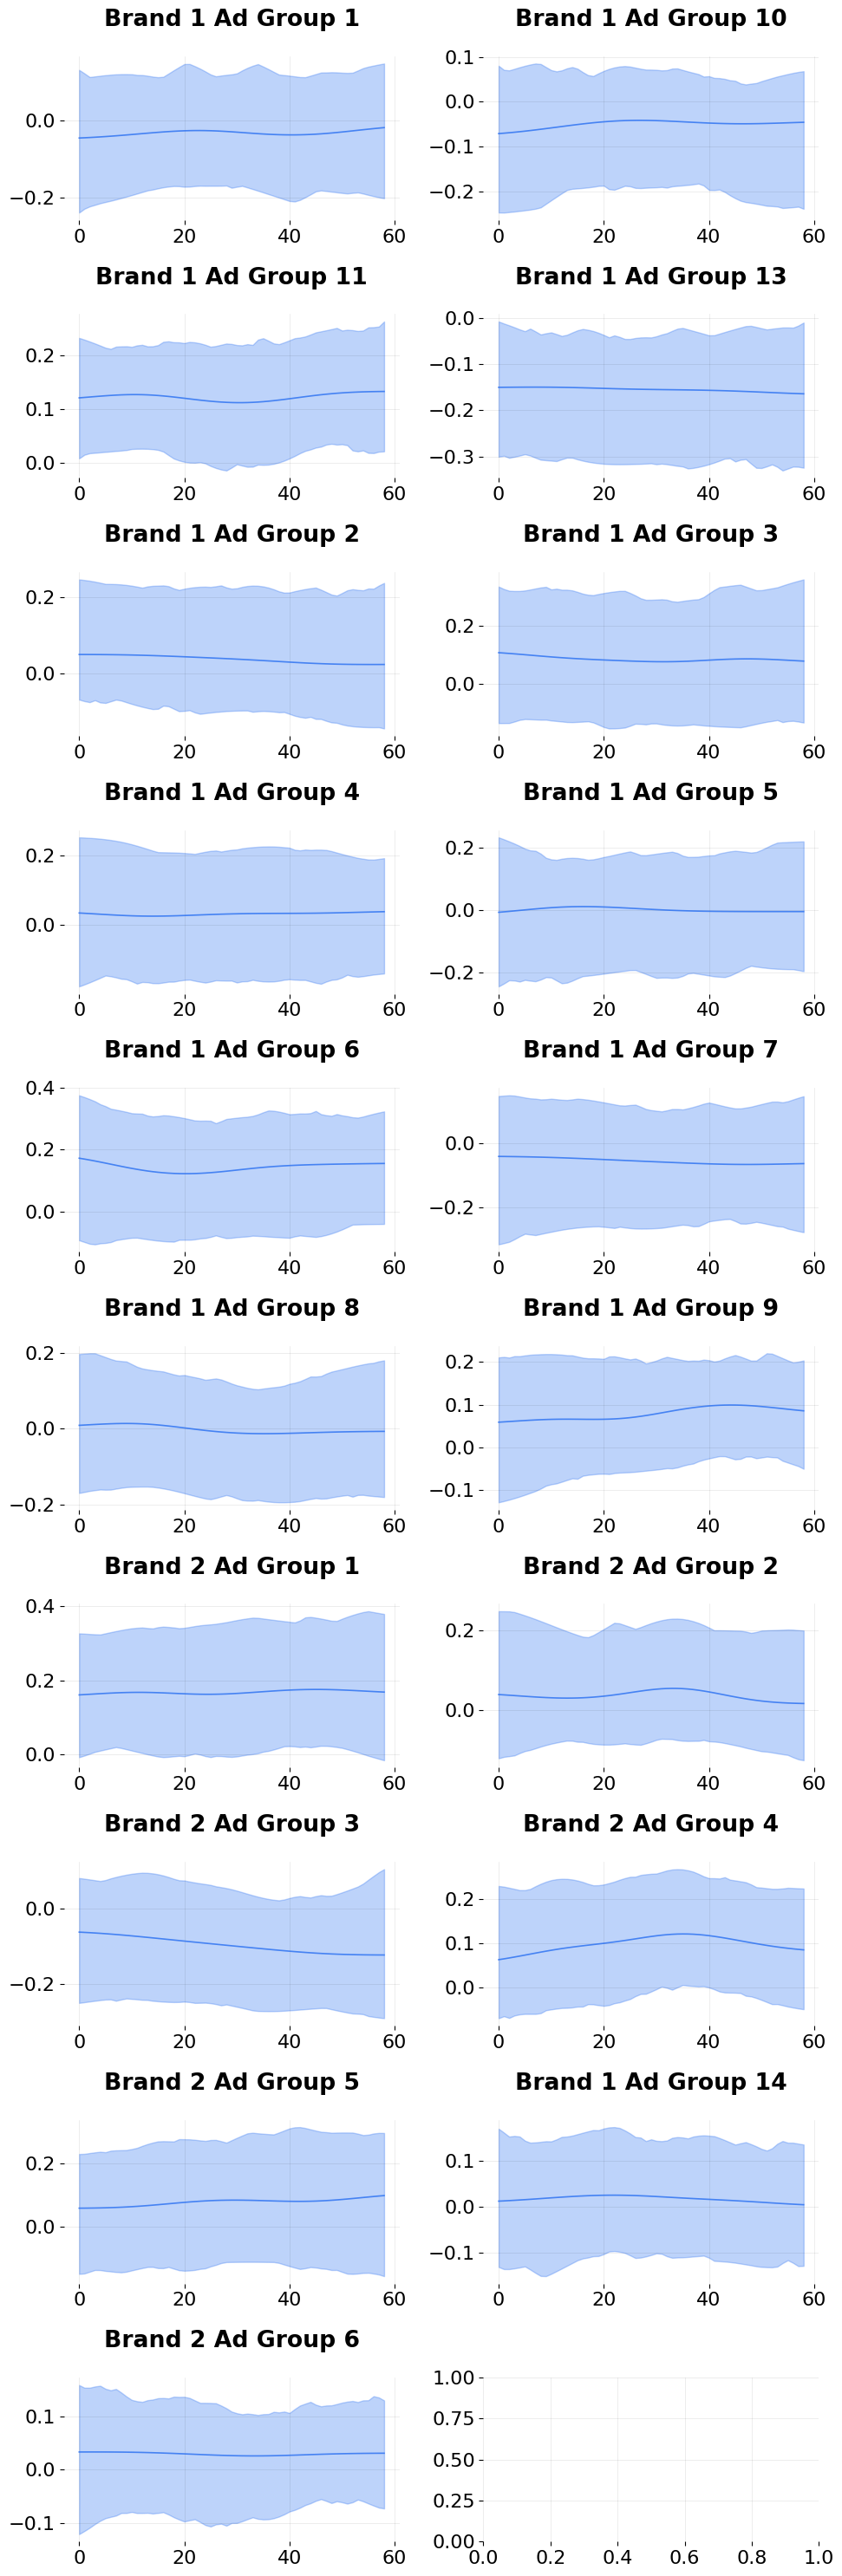

array([[<Axes: title={'center': 'Brand 1 Ad Group 1'}>,
        <Axes: title={'center': 'Brand 1 Ad Group 10'}>],
       [<Axes: title={'center': 'Brand 1 Ad Group 11'}>,
        <Axes: title={'center': 'Brand 1 Ad Group 13'}>],
       [<Axes: title={'center': 'Brand 1 Ad Group 2'}>,
        <Axes: title={'center': 'Brand 1 Ad Group 3'}>],
       [<Axes: title={'center': 'Brand 1 Ad Group 4'}>,
        <Axes: title={'center': 'Brand 1 Ad Group 5'}>],
       [<Axes: title={'center': 'Brand 1 Ad Group 6'}>,
        <Axes: title={'center': 'Brand 1 Ad Group 7'}>],
       [<Axes: title={'center': 'Brand 1 Ad Group 8'}>,
        <Axes: title={'center': 'Brand 1 Ad Group 9'}>],
       [<Axes: title={'center': 'Brand 2 Ad Group 1'}>,
        <Axes: title={'center': 'Brand 2 Ad Group 2'}>],
       [<Axes: title={'center': 'Brand 2 Ad Group 3'}>,
        <Axes: title={'center': 'Brand 2 Ad Group 4'}>],
       [<Axes: title={'center': 'Brand 2 Ad Group 5'}>,
        <Axes: title={'center': 'Bran

In [12]:
ktr_.plot_regression_coefs(figsize=(10, 30), include_ci=True)

## Estimating Return on Investment (ROI)

<Axes: >

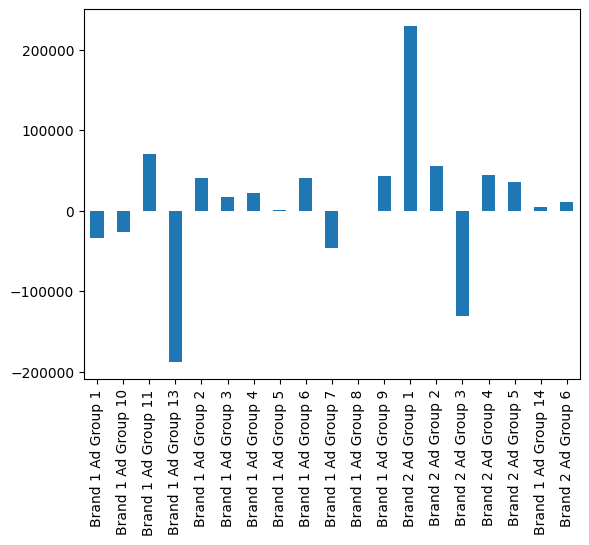

In [13]:
contribution = scaler_y.inverse_transform(ktr_.get_regression_coefs().iloc[:, 1:] * media_data_train[regressor_col])
contribution = pd.DataFrame(contribution,columns=regressor_col).sum(axis=0)
contribution.plot(kind='bar')

<Axes: xlabel='Ad group alias'>

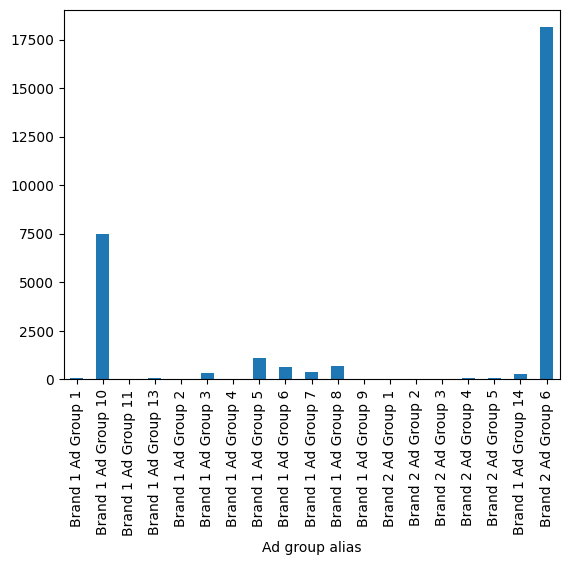

In [14]:
roi = (contribution.sum(axis=0) / costs_raw.sum(axis=0)).clip(0)
roi.plot(kind='bar')

## Optimizing Advertising Budgets

In [15]:
cpi = costs_raw.sum(axis=0) / media_data_raw.sum(axis=0)
cpi = cpi[regressor_col]

def opt_fun(*x):
  x = np.array(x).reshape(1,-1)
  
  x_ = media_data_raw.iloc[-1:].copy()
  x_['Date'] = x_['Date'] + pd.Timedelta(1, "D")

  x = pd.DataFrame(x, columns=regressor_col)
  cost = (cpi * x).squeeze().sum() # unlimited budget
  if cost > 2000:
    return 1

  x__ = scaler.transform(x)
  x_[regressor_col] = x__

  p = scaler_y.inverse_transform(ktr_.predict(x_)['prediction'].values.reshape(-1,1))[0][0]
  return -(p / cost)

<ipython-input-15-b54df088fba8>:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cpi = costs_raw.sum(axis=0) / media_data_raw.sum(axis=0)


In [16]:
import nevergrad as ng

params = ng.p.Instrumentation(*[ng.p.Scalar(lower=0, upper=b*1.1) for b in media_data_raw.max(axis=0).iloc[1:-1].values])
optimizer = ng.optimizers.RandomSearch(parametrization=params, budget=100)
recommendation = optimizer.minimize(opt_fun) 
print(recommendation.value)

((9328.983336388314, 103.40748151005408, 44851.59809537498, 245.6075690079001, 33539.5792512183, 3294.5390110051303, 163207.53829797974, 319.6203499180453, 1390.2828474007772, 1412.8955260625728, 709.9168023828688, 824.8124857073462, 83870.78851195304, 257069.35035720022, 85483.92874301407, 71016.02785791481, 61126.91751455682, 63510.435721856695, 759.4647118229315), {})


In [ ]:
from orbit.diagnostics.plot import plot_predicted_components, plot_predicted_data
predicted_df = ktr_.predict(df=media_data_test, decompose=True)
_ = plot_predicted_components(predicted_df, date_col)

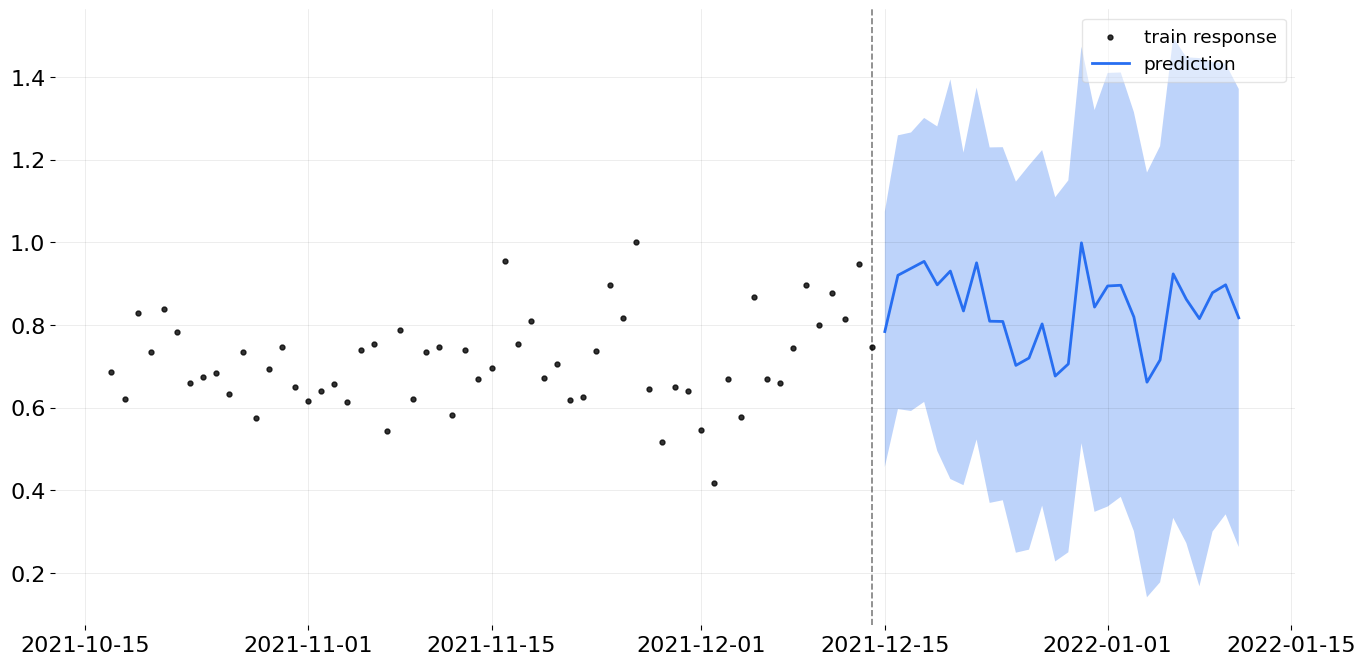

In [18]:
_ = plot_predicted_data(media_data_train, predicted_df, date_col, response_col)

In [19]:
#Shape
unscaled_pred = scaler_y.inverse_transform(predicted_df['prediction'].values.reshape(-1,1))
unscaled_actual = media_data_raw.iloc[split_point:][response_col].values.reshape(-1,1)
smape(unscaled_pred, unscaled_actual)

0.1762117389937244